# 1. Standard (not graph) AE + GNN for node classification from AE codings

##

In [3]:
!pip install torch_geometric

In [7]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from sklearn.neighbors import kneighbors_graph
import numpy as np
from torch_geometric.data import Data
from scipy.sparse import coo_matrix
import random
from utils import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the Fashion-MNIST dataset
def load_fmnist():
    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = datasets.FashionMNIST(root='.', train=True, transform=transform, download=True)
    return train_dataset

# Convert images to feature vectors
def preprocess_data(dataset):
    data = dataset.data.numpy()
    num_samples = data.shape[0]
    data = data.reshape(num_samples, -1) / 255.0
    labels = dataset.targets.numpy()
    return data, labels

# Create a KNN graph and add a random neighbor for each node
def create_knn_graph_with_random_neighbor(data, k):
    knn_graph = kneighbors_graph(data, k, mode='connectivity', include_self=False)
    coo = coo_matrix(knn_graph)
    row = coo.row.tolist()
    col = coo.col.tolist()

    # Add one random neighbor for each node
    num_samples = data.shape[0]
    for i in range(num_samples):
        random_neighbor = random.choice(range(num_samples))
        row.append(i)
        col.append(random_neighbor)

    new_knn_graph = coo_matrix((np.ones(len(row)), (row, col)), shape=(num_samples, num_samples))
    return new_knn_graph

# Convert the sparse matrix to edge_index format for PyTorch Geometric
def convert_to_torch_geometric_graph(knn_graph):
    coo = coo_matrix(knn_graph)
    edge_index = torch.tensor(np.vstack((coo.row, coo.col)), dtype=torch.long)
    return edge_index

# Main function to execute the steps
def main():
    # Load and preprocess the data
    train_dataset = load_fmnist()
    x_train, y_train = preprocess_data(train_dataset)

    # Use a subset of the data for simplicity (e.g., first 1000 samples)
    x_subset = x_train[:10000]
    y_subset = y_train[:10000]

    # Create KNN graph with an additional random neighbor
    k = 4  # Number of neighbors
    knn_graph = create_knn_graph_with_random_neighbor(x_subset, k)

    # Convert to PyTorch Geometric Data object
    edge_index = convert_to_torch_geometric_graph(knn_graph)
    x = torch.tensor(x_subset, dtype=torch.float)
    y = torch.tensor(y_subset, dtype=torch.long)
    data = Data(x=x, edge_index=edge_index, y=y)

    # Set additional attributes for compatibility
    data.num_node_features = data.x.shape[1]
    data.num_classes = len(torch.unique(data.y))
    data.num_features = data.num_node_features

    # Print the Data object to verify
    print(data)
    print(f"Number of node features: {data.num_node_features}")
    print(f"Number of classes: {data.num_classes}")
    print(f"Number of features: {data.num_features}")

    return data

# data = main()
# # Assuming generate_train_test is a function you have from utils or elsewhere
# generate_train_test(data)


In [3]:
import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv
from utils import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Define the Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, bottleneck_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, bottleneck_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Define the GCN model
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)



# Autoencoder Settings
input_dim = data.num_node_features
hidden_dim = 128
bottleneck_dim = 32
autoencoder = Autoencoder(input_dim, hidden_dim, bottleneck_dim)

# Training the Autoencoder
optimizer_ae = torch.optim.Adam(autoencoder.parameters(), lr=0.01)
criterion_ae = nn.MSELoss()

for epoch in range(200):
    autoencoder.train()
    optimizer_ae.zero_grad()
    _, reconstructed = autoencoder(data.x)
    loss = criterion_ae(reconstructed, data.x)
    loss.backward()
    optimizer_ae.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Preparing the compressed features for the GNN
autoencoder.eval()
with torch.no_grad():  # Ensure no gradients are computed for the operation within this block
    compressed_features, _ = autoencoder(data.x)
    compressed_features = compressed_features.detach()  # Detach the features from the graph


# Training the GNN
gcn = GCN(bottleneck_dim, hidden_dim, data.num_classes)
optimizer_gcn = torch.optim.Adam(gcn.parameters(), lr=0.01)
criterion_gcn = torch.nn.CrossEntropyLoss()

for epoch in range(200):
    gcn.train()
    optimizer_gcn.zero_grad()
    out = gcn(compressed_features, data.edge_index)
    loss = criterion_gcn(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer_gcn.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')


Epoch 0, Loss: 0.17097420990467072
Epoch 10, Loss: 0.06564898043870926
Epoch 20, Loss: 0.04853939265012741
Epoch 30, Loss: 0.04013746976852417
Epoch 40, Loss: 0.03561478853225708
Epoch 50, Loss: 0.030756760388612747
Epoch 60, Loss: 0.027647430077195168
Epoch 70, Loss: 0.025597531348466873
Epoch 80, Loss: 0.02548184245824814
Epoch 90, Loss: 0.024099495261907578
Epoch 100, Loss: 0.02307344786822796
Epoch 110, Loss: 0.02276160940527916
Epoch 120, Loss: 0.022575989365577698
Epoch 130, Loss: 0.02178356982767582
Epoch 140, Loss: 0.02125670574605465
Epoch 150, Loss: 0.02055267244577408
Epoch 160, Loss: 0.020080920308828354
Epoch 170, Loss: 0.019654113799333572
Epoch 180, Loss: 0.019637102261185646
Epoch 190, Loss: 0.019206183031201363
Epoch 0, Loss: 3.1599345207214355
Epoch 10, Loss: 1.3700075149536133
Epoch 20, Loss: 1.214152216911316
Epoch 30, Loss: 1.1586732864379883
Epoch 40, Loss: 1.1327931880950928
Epoch 50, Loss: 1.1093076467514038
Epoch 60, Loss: 1.0941393375396729
Epoch 70, Loss: 1.0

In [4]:
# Switch model to evaluation mode
gcn.eval()

# No gradient calculation needed for evaluation
with torch.no_grad():
    # Forward pass with the test data
    test_out = gcn(compressed_features, data.edge_index)
    # Use the class with the highest probability as the prediction
    test_pred = test_out.argmax(dim=1)
    # Calculate the number of correct predictions in the test set
    correct = (test_pred[data.test_mask] == data.y[data.test_mask]).sum().item()
    # Calculate the test accuracy
    test_accuracy = correct / data.test_mask.sum().item()




##

In [5]:
print(f'Test Accuracy: {test_accuracy}')

Test Accuracy: 0.6678333333333333


This obviously does not work. Let's try to fix it.

# 2. Basic Graph AE + GNN for node classification from AE codings
super basic 2 GCNConv layers  
2-dim output

##

In [8]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.utils import train_test_split_edges

data = main()
generate_train_test(data)

class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
# data.train_mask = data.val_mask = data.test_mask = data.y = None  # Ensure these are not used by train_test_split_edges
data = train_test_split_edges(data)

class GNNNodeClassifier(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNNNodeClassifier, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels, cached=True)
        self.conv2 = GCNConv(hidden_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Parameters
out_channels = 2
num_features = data.num_features
num_classes = data.num_classes
epochs = 100
hidden_channels = 16

# Model initialization
model = GAE(GCNEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Update data.x with the encoded features for classification
data.x = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach()

# Initialize the GNN model for node classification
gnn_model = GNNNodeClassifier(out_channels, hidden_channels, num_classes).to(device)
optimizer_gnn = torch.optim.Adam(gnn_model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Reconstruct full edge_index from the split edges for training the GNN
full_edge_index = torch.cat([data.train_pos_edge_index, data.val_pos_edge_index, data.test_pos_edge_index], dim=-1).to(device)

# Training the GNN model
for epoch in range(100):
    gnn_model.train()
    optimizer_gnn.zero_grad()
    out = gnn_model(data.x, full_edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask].to(device))
    loss.backward()
    optimizer_gnn.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Evaluation
gnn_model.eval()
with torch.no_grad():
    out = gnn_model(data.x, full_edge_index)
    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask].to(device)).sum()
    acc = correct.float() / data.test_mask.sum().float()


Data(x=[10000, 784], edge_index=[2, 50000], y=[10000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 1.3862955570220947
Epoch: 20, Loss: 1.3862979412078857
Epoch: 30, Loss: 1.3862991333007812
Epoch: 40, Loss: 1.3862998485565186
Epoch: 50, Loss: 1.3863000869750977
Epoch: 60, Loss: 1.3863000869750977
Epoch: 70, Loss: 1.3863000869750977
Epoch: 80, Loss: 1.3863000869750977
Epoch: 90, Loss: 1.386299967765808
Epoch: 100, Loss: 1.3862998485565186
Epoch 0, Loss: 2.302523136138916
Epoch 10, Loss: 2.301928758621216
Epoch 20, Loss: 2.302011013031006
Epoch 30, Loss: 2.3022797107696533
Epoch 40, Loss: 2.301677703857422
Epoch 50, Loss: 2.301382064819336
Epoch 60, Loss: 2.3014087677001953
Epoch 70, Loss: 2.3012051582336426
Epoch 80, Loss: 2.3016743659973145
Epoch 90, Loss: 2.3016865253448486


##

In [9]:
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.1045


# 3. Basic Graph AE + GNN for node classification from AE codings
super basic 2 GCNConv layers  
16-dim output

##

In [10]:
data = main()
generate_train_test(data)

Data(x=[10000, 784], edge_index=[2, 50000], y=[10000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [11]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.utils import train_test_split_edges

class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
# data.train_mask = data.val_mask = data.test_mask = data.y = None  # Ensure these are not used by train_test_split_edges
data = train_test_split_edges(data)

class GNNNodeClassifier(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNNNodeClassifier, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels, cached=True)
        self.conv2 = GCNConv(hidden_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Parameters
out_channels = 16
num_features = data.num_features
num_classes = data.num_classes
epochs = 100
hidden_channels = 32

# Model initialization
model = GAE(GCNEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Update data.x with the encoded features for classification
data.x = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach()

# Initialize the GNN model for node classification
gnn_model = GNNNodeClassifier(out_channels, hidden_channels, num_classes).to(device)
optimizer_gnn = torch.optim.Adam(gnn_model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Reconstruct full edge_index from the split edges for training the GNN
full_edge_index = torch.cat([data.train_pos_edge_index, data.val_pos_edge_index, data.test_pos_edge_index], dim=-1).to(device)

# Training the GNN model
for epoch in range(100):
    gnn_model.train()
    optimizer_gnn.zero_grad()
    out = gnn_model(data.x, full_edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask].to(device))
    loss.backward()
    optimizer_gnn.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Evaluation
gnn_model.eval()
with torch.no_grad():
    out = gnn_model(data.x, full_edge_index)
    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask].to(device)).sum()
    acc = correct.float() / data.test_mask.sum().float()



/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 34.53877258300781
Epoch: 20, Loss: 34.53877258300781
Epoch: 30, Loss: 34.53877258300781
Epoch: 40, Loss: 34.53877258300781
Epoch: 50, Loss: 34.53877258300781
Epoch: 60, Loss: 34.53877258300781
Epoch: 70, Loss: 34.53877258300781
Epoch: 80, Loss: 34.53877258300781
Epoch: 90, Loss: 34.53877258300781
Epoch: 100, Loss: 34.53877258300781
Epoch 0, Loss: 12.601744651794434
Epoch 10, Loss: 2.840022563934326
Epoch 20, Loss: 2.2989771366119385
Epoch 30, Loss: 2.2877695560455322
Epoch 40, Loss: 2.278794765472412
Epoch 50, Loss: 2.271883249282837
Epoch 60, Loss: 2.25868821144104
Epoch 70, Loss: 2.2435693740844727
Epoch 80, Loss: 2.2241146564483643
Epoch 90, Loss: 2.201138496398926


##

In [12]:
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.1460


# 4. Basic Graph AE for DR
super basic 2 GCNConv layers  
2-dim output straight for visualisation

##

In [13]:
data = main()
generate_train_test(data)

Data(x=[10000, 784], edge_index=[2, 50000], y=[10000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [14]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.utils import train_test_split_edges
import matplotlib.pyplot as plt

class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 2  # Set to 2 for 2D visualization
num_features = data.num_features

model = GAE(GCNEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 101):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Visualization of the 2D encoded features
labels = data.y.cpu().numpy()



/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 1.3862946033477783
Epoch: 20, Loss: 1.3862988948822021
Epoch: 30, Loss: 1.3863017559051514
Epoch: 40, Loss: 1.386303424835205
Epoch: 50, Loss: 1.3863039016723633
Epoch: 60, Loss: 1.3863036632537842
Epoch: 70, Loss: 1.386303186416626
Epoch: 80, Loss: 1.3863029479980469
Epoch: 90, Loss: 1.3863024711608887
Epoch: 100, Loss: 1.3863022327423096


##

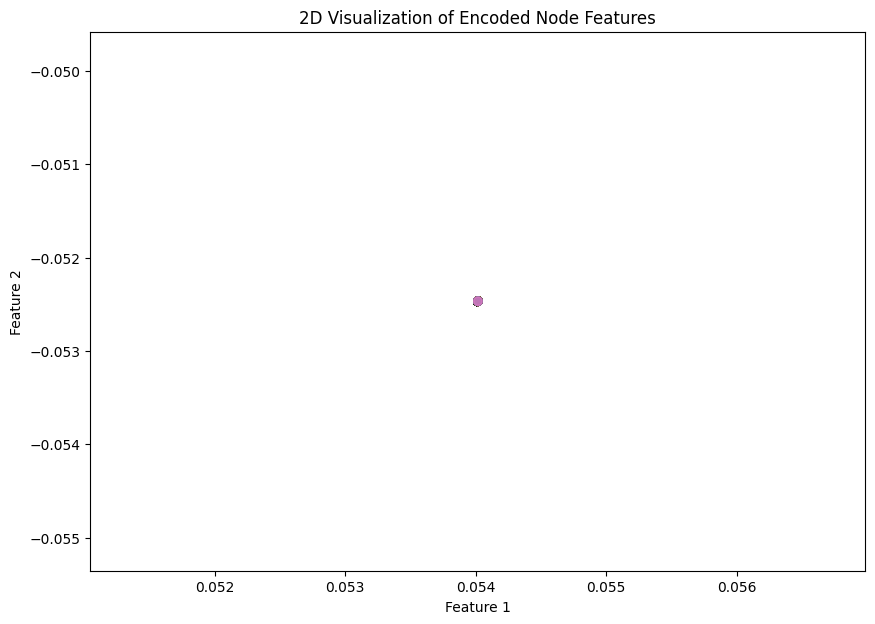

In [15]:
visualise(encoded_features, labels, '2D Visualization of Encoded Node Features')

# 5. Basic Graph AE + tSNE
super basic 2 GCNConv layers  
16-dim output -> tSNE (2dim)

##

In [16]:
data = main()
generate_train_test(data)

Data(x=[10000, 784], edge_index=[2, 50000], y=[10000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [17]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.utils import train_test_split_edges
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# Parameters for the encoder
out_channels = 16  # Increase the capacity
num_features = data.num_features

# Model initialization
model = GAE(GCNEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Add weight decay for L2 regularization

# Training the GAE model
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode to a higher dimension for better representation, then use t-SNE
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Apply t-SNE to the encoded features
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_results = tsne.fit_transform(encoded_features)



Epoch: 10, Loss: 9.476578712463379
Epoch: 20, Loss: 1.353870153427124
Epoch: 30, Loss: 1.3459458351135254
Epoch: 40, Loss: 1.341280460357666
Epoch: 50, Loss: 1.328284502029419
Epoch: 60, Loss: 1.318673849105835
Epoch: 70, Loss: 1.3076850175857544
Epoch: 80, Loss: 1.296330451965332
Epoch: 90, Loss: 1.2838702201843262
Epoch: 100, Loss: 1.2760521173477173
Epoch: 110, Loss: 1.2711652517318726
Epoch: 120, Loss: 1.257110357284546
Epoch: 130, Loss: 1.247814655303955
Epoch: 140, Loss: 1.2394441366195679
Epoch: 150, Loss: 1.2300684452056885
Epoch: 160, Loss: 1.2267060279846191
Epoch: 170, Loss: 1.2164719104766846
Epoch: 180, Loss: 1.2146859169006348
Epoch: 190, Loss: 1.207458257675171
Epoch: 200, Loss: 1.2035455703735352


##

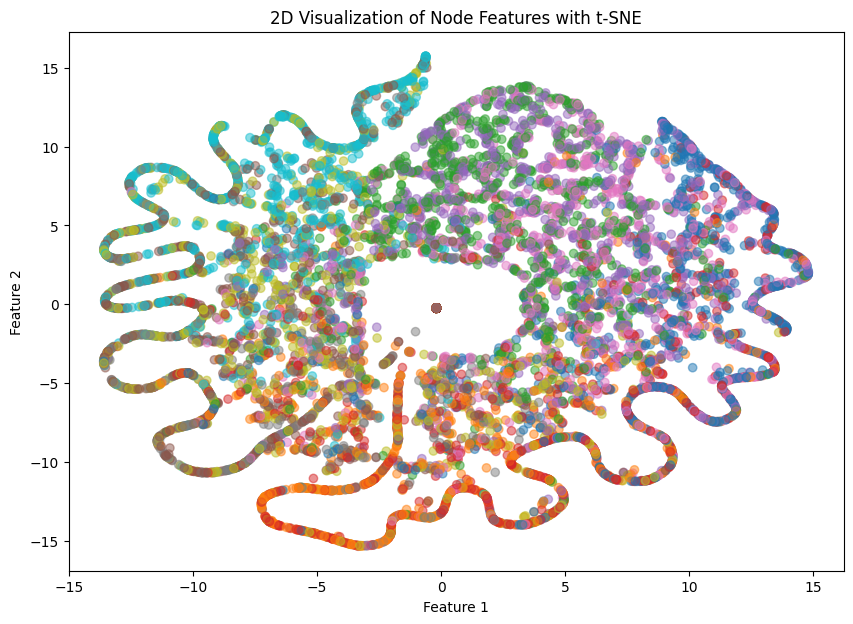

In [18]:
visualise(tsne_results, labels, '2D Visualization of Node Features with t-SNE')

# 6. Graph AE with skip connections +tSNE
Three GCNConv layers with a skip connection

##

In [19]:
data = main()
generate_train_test(data)

Data(x=[10000, 784], edge_index=[2, 50000], y=[10000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [20]:
class EnhancedGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EnhancedGCNEncoder, self).__init__()
        self.base_conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.base_conv2 = GCNConv(2 * out_channels, 2 * out_channels, cached=True)
        self.skip_conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)  # Skip connection
        self.conv3 = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        skip1 = F.relu(self.skip_conv1(x, edge_index))
        x = F.relu(self.base_conv1(x, edge_index))
        x = F.relu(self.base_conv2(x + skip1, edge_index))  # Combine with skip connection
        return self.conv3(x, edge_index)

# Parameters for the encoder
out_channels = 16  # Increase the capacity
num_features = data.num_features

# Model initialization
model = GAE(EnhancedGCNEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Add weight decay for L2 regularization

# Training the GAE model
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode to a higher dimension for better representation, then use t-SNE
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Apply t-SNE to the encoded features
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, metric='cosine')
tsne_results = tsne.fit_transform(encoded_features)

# Visualization of the 2D t-SNE results
labels = data.y.cpu().numpy()



Epoch: 10, Loss: 1.346283197402954
Epoch: 20, Loss: 1.361262321472168
Epoch: 30, Loss: 1.3261363506317139
Epoch: 40, Loss: 1.289505124092102
Epoch: 50, Loss: 1.2702958583831787
Epoch: 60, Loss: 1.2592161893844604
Epoch: 70, Loss: 1.2620306015014648
Epoch: 80, Loss: 1.256300926208496
Epoch: 90, Loss: 1.249480962753296
Epoch: 100, Loss: 1.1916303634643555
Epoch: 110, Loss: 1.2093844413757324
Epoch: 120, Loss: 1.18626070022583
Epoch: 130, Loss: 1.181288719177246
Epoch: 140, Loss: 1.1751600503921509
Epoch: 150, Loss: 1.1788616180419922
Epoch: 160, Loss: 1.1734886169433594
Epoch: 170, Loss: 1.1733784675598145
Epoch: 180, Loss: 1.1758923530578613
Epoch: 190, Loss: 1.1764273643493652
Epoch: 200, Loss: 1.173372507095337


##

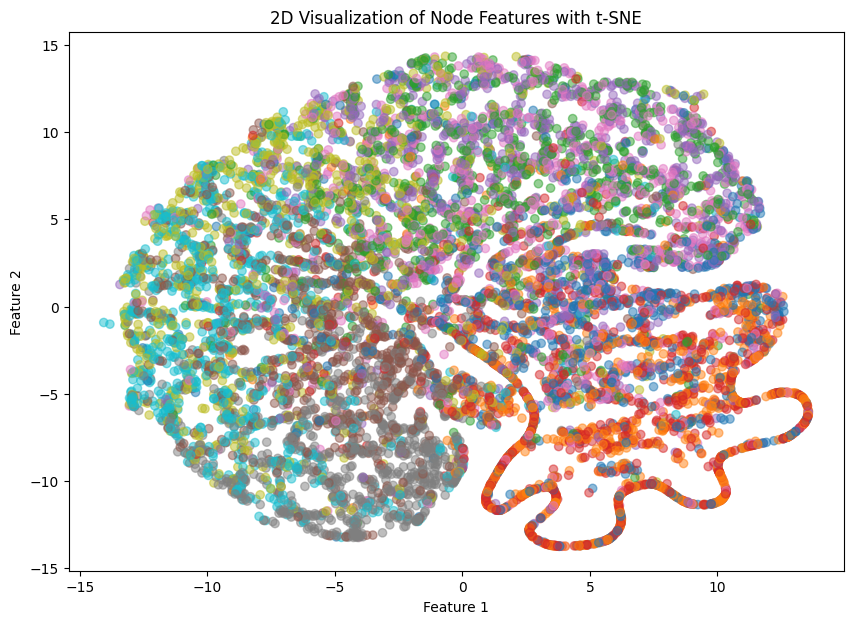

In [21]:
visualise(tsne_results, labels, '2D Visualization of Node Features with t-SNE')

# 7. Graph AE with skip connections
Three GCNConv layers with a skip connection

##

In [22]:
data = main()
generate_train_test(data)

Data(x=[10000, 784], edge_index=[2, 50000], y=[10000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [23]:
# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 2  # Set to 2 for 2D visualization
num_features = data.num_features

model = GAE(EnhancedGCNEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 101):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Visualization of the 2D encoded features
labels = data.y.cpu().numpy()



/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 1.3674641847610474
Epoch: 20, Loss: 1.3503504991531372
Epoch: 30, Loss: 1.3306035995483398
Epoch: 40, Loss: 1.3075964450836182
Epoch: 50, Loss: 1.2773382663726807
Epoch: 60, Loss: 1.2514967918395996
Epoch: 70, Loss: 1.2316771745681763
Epoch: 80, Loss: 1.2263131141662598
Epoch: 90, Loss: 1.2228375673294067
Epoch: 100, Loss: 1.2200181484222412


##

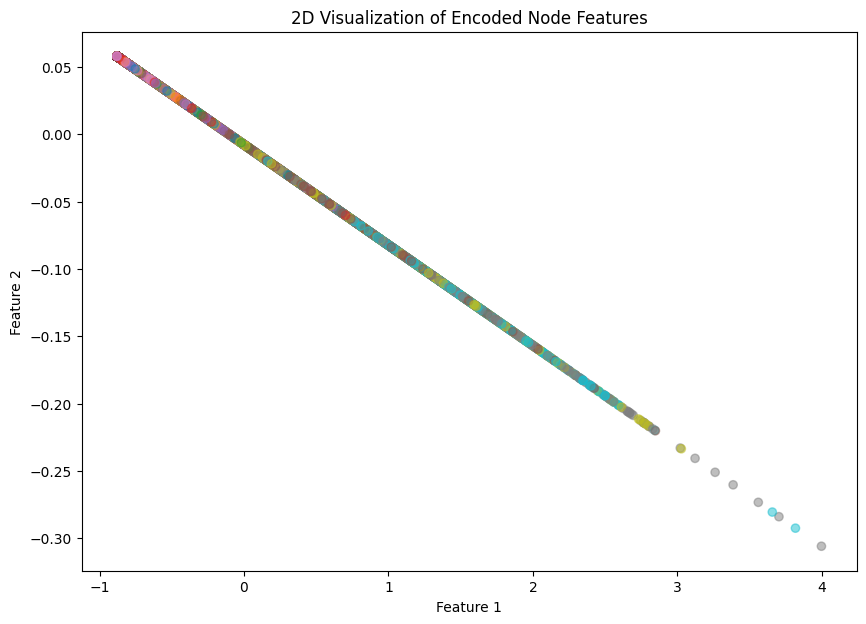

In [24]:
visualise(encoded_features, labels, '2D Visualization of Encoded Node Features')


# 8. Graph AE with attention
Two GATConv layers.

##

In [25]:
data = main()
generate_train_test(data)

Data(x=[10000, 784], edge_index=[2, 50000], y=[10000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [26]:
from torch_geometric.nn import GATConv

class GATEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GATEncoder, self).__init__()
        self.conv1 = GATConv(in_channels, 2 * out_channels, heads=8, dropout=0.6)
        # Concatenate multi-head outputs so the final output will be 2*out_channels*8
        self.conv2 = GATConv(2 * out_channels * 8, out_channels, heads=1, concat=False, dropout=0.6)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 2  # Set to 2 for 2D visualization
num_features = data.num_features

model = GAE(GATEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 11.975153923034668
Epoch: 20, Loss: 6.945417881011963
Epoch: 30, Loss: 5.757032871246338
Epoch: 40, Loss: 4.547665596008301
Epoch: 50, Loss: 4.454340934753418
Epoch: 60, Loss: 3.8292763233184814
Epoch: 70, Loss: 3.4038472175598145
Epoch: 80, Loss: 3.341359853744507
Epoch: 90, Loss: 3.0780653953552246
Epoch: 100, Loss: 2.897886276245117
Epoch: 110, Loss: 2.985039710998535
Epoch: 120, Loss: 2.8857712745666504
Epoch: 130, Loss: 2.755702018737793
Epoch: 140, Loss: 2.6217265129089355
Epoch: 150, Loss: 2.6748600006103516
Epoch: 160, Loss: 2.599792242050171
Epoch: 170, Loss: 2.430392265319824
Epoch: 180, Loss: 2.4615817070007324
Epoch: 190, Loss: 2.380143404006958
Epoch: 200, Loss: 2.280308246612549


##

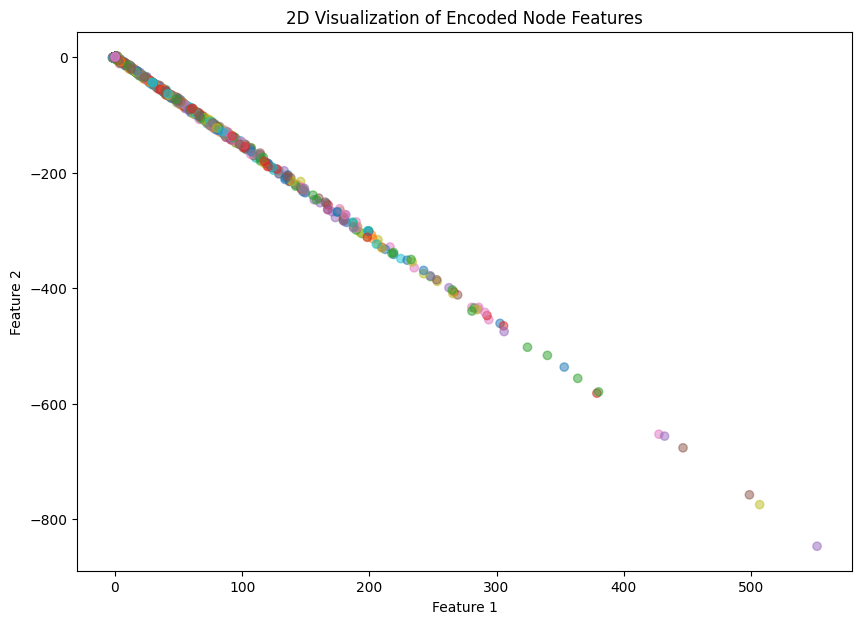

In [27]:
visualise(encoded_features, labels, '2D Visualization of Encoded Node Features')

# 8. Graph AE with attention + tSNE
Two GATConv layers.

##

In [28]:
data = main()
generate_train_test(data)

Data(x=[10000, 784], edge_index=[2, 50000], y=[10000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [29]:
# Parameters for the encoder
out_channels = 16  # Increase the capacity
num_features = data.num_features

# Model initialization
model = GAE(GATEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Add weight decay for L2 regularization

# Training the GAE model
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode to a higher dimension for better representation, then use t-SNE
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Apply t-SNE to the encoded features
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, metric='cosine')
tsne_results = tsne.fit_transform(encoded_features)

# Visualization of the 2D t-SNE results
labels = data.y.cpu().numpy()




Epoch: 10, Loss: 7.076238632202148
Epoch: 20, Loss: 7.387691497802734
Epoch: 30, Loss: 6.993747234344482
Epoch: 40, Loss: 6.974300861358643
Epoch: 50, Loss: 6.682811737060547
Epoch: 60, Loss: 6.744581699371338
Epoch: 70, Loss: 6.395057201385498
Epoch: 80, Loss: 6.259793281555176
Epoch: 90, Loss: 6.285031318664551
Epoch: 100, Loss: 6.500295162200928
Epoch: 110, Loss: 7.831392288208008
Epoch: 120, Loss: 6.630256652832031
Epoch: 130, Loss: 5.864053249359131
Epoch: 140, Loss: 6.024959087371826
Epoch: 150, Loss: 6.747347354888916
Epoch: 160, Loss: 8.330693244934082
Epoch: 170, Loss: 6.807967185974121
Epoch: 180, Loss: 6.166006088256836
Epoch: 190, Loss: 6.193356037139893
Epoch: 200, Loss: 6.085099220275879


##

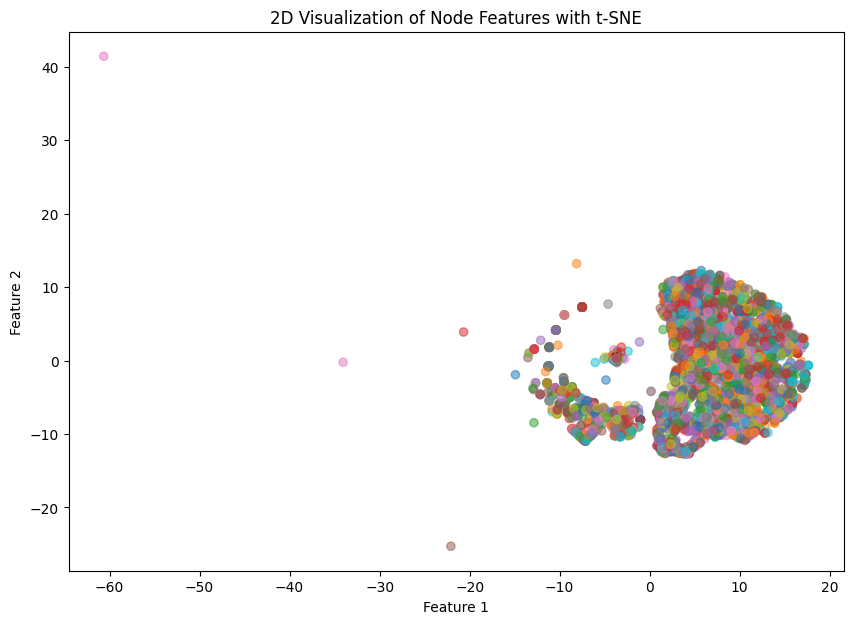

In [30]:
visualise(tsne_results, labels, '2D Visualization of Node Features with t-SNE')

# 9. Graph AE with skip & residual connections
3 GCNConv layers with skip connections.

##

In [31]:
data = main()
generate_train_test(data)

Data(x=[10000, 784], edge_index=[2, 50000], y=[10000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [32]:
class ComplexGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(ComplexGCNEncoder, self).__init__()
        # Encoder with skip connections
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.skip_conv1 = GCNConv(in_channels, out_channels)

    def forward(self, x, edge_index):
        skip1 = F.relu(self.skip_conv1(x, edge_index))
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index)) + x  # Residual connection
        x = self.conv3(x, edge_index) + skip1  # Skip connection
        return x

# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 2  # Set to 2 for 2D visualization
num_features = data.num_features
hidden_channels=16

model = GAE(ComplexGCNEncoder(num_features, hidden_channels, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Visualization of the 2D encoded features
labels = data.y.cpu().numpy()



/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 1.3593831062316895
Epoch: 20, Loss: 1.342766523361206
Epoch: 30, Loss: 1.3211815357208252
Epoch: 40, Loss: 1.2932558059692383
Epoch: 50, Loss: 1.2589777708053589
Epoch: 60, Loss: 1.2267136573791504
Epoch: 70, Loss: 1.203932523727417
Epoch: 80, Loss: 1.1963329315185547
Epoch: 90, Loss: 1.1928367614746094
Epoch: 100, Loss: 1.1946591138839722
Epoch: 110, Loss: 1.1862379312515259
Epoch: 120, Loss: 1.186628818511963
Epoch: 130, Loss: 1.185982584953308
Epoch: 140, Loss: 1.185018539428711
Epoch: 150, Loss: 1.1867573261260986
Epoch: 160, Loss: 1.1820955276489258
Epoch: 170, Loss: 1.1805200576782227
Epoch: 180, Loss: 1.1827006340026855
Epoch: 190, Loss: 1.1784508228302002
Epoch: 200, Loss: 1.1949462890625


##

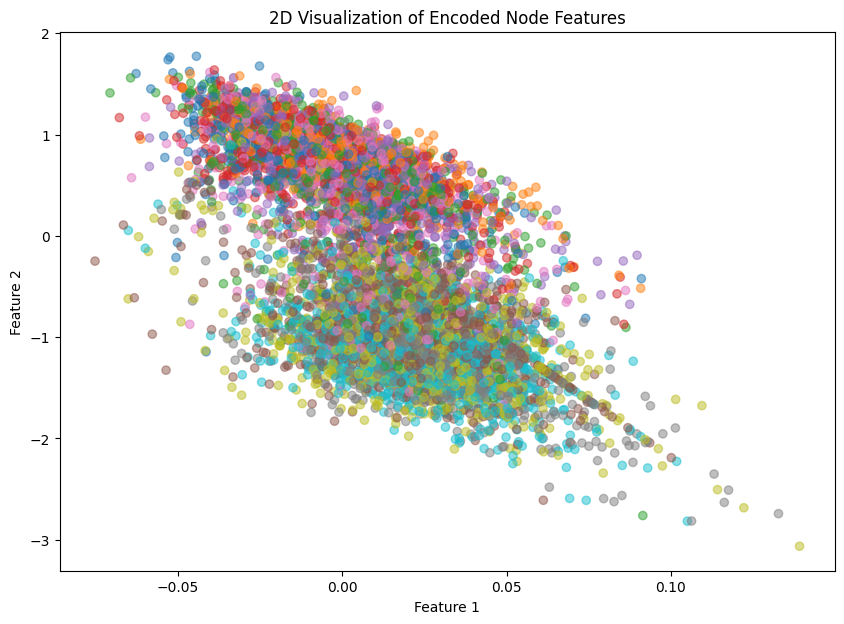

In [33]:
visualise(encoded_features, labels, '2D Visualization of Encoded Node Features')

# 10. Graph AE with residual connection
Three GCNConv layers with a residual connection.

##

In [34]:
data = main()
generate_train_test(data)

Data(x=[10000, 784], edge_index=[2, 50000], y=[10000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [35]:
class ResidualGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(ResidualGCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        # Residual connection from input to output
        self.shortcut = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        identity = x

        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))

        if x.size(-1) != identity.size(-1):
            identity = self.shortcut(identity)

        x = self.conv3(x, edge_index)

        x += identity  # Add the input to the output
        return x

# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 2  # Set to 2 for 2D visualization
num_features = data.num_features
hidden_channels=16

model = GAE(ResidualGCNEncoder(num_features, hidden_channels, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Visualization of the 2D encoded features
labels = data.y.cpu().numpy()



/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 1.3368587493896484
Epoch: 20, Loss: 1.5887739658355713
Epoch: 30, Loss: 1.268110990524292
Epoch: 40, Loss: 1.2599667310714722
Epoch: 50, Loss: 1.2522530555725098
Epoch: 60, Loss: 1.2463066577911377
Epoch: 70, Loss: 1.235809564590454
Epoch: 80, Loss: 1.2050080299377441
Epoch: 90, Loss: 1.1836024522781372
Epoch: 100, Loss: 1.1779930591583252
Epoch: 110, Loss: 1.1779783964157104
Epoch: 120, Loss: 1.177581548690796
Epoch: 130, Loss: 1.1806087493896484
Epoch: 140, Loss: 1.173843264579773
Epoch: 150, Loss: 1.172092318534851
Epoch: 160, Loss: 1.1733258962631226
Epoch: 170, Loss: 1.1707550287246704
Epoch: 180, Loss: 1.170102596282959
Epoch: 190, Loss: 1.1718813180923462
Epoch: 200, Loss: 1.1705012321472168


##

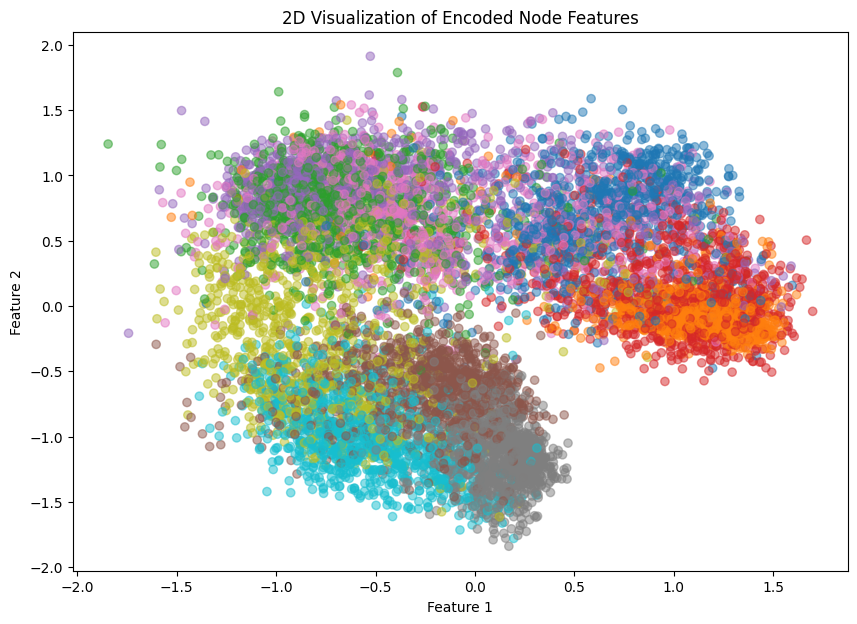

In [36]:
visualise(encoded_features, labels, '2D Visualization of Encoded Node Features')

# 11. Graph AE with attention & normalization
Two GATConv layers with layer normalization.

##

In [37]:
data = main()
generate_train_test(data)

Data(x=[10000, 784], edge_index=[2, 50000], y=[10000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [38]:
from torch_geometric.nn import GATConv, LayerNorm

class GATWithLayerNormEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=3, dropout_rate=0.6):
        super(GATWithLayerNormEncoder, self).__init__()
        # Define the first layer with multiple heads
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout_rate)
        # For the second layer, we want to reduce the dimension to our desired output dimension
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout_rate)
        # Layer normalization
        self.ln1 = LayerNorm(hidden_channels * heads)
        self.ln2 = LayerNorm(out_channels)

    def forward(self, x, edge_index, dropout_rate=0.6):
        x = F.dropout(x, p=dropout_rate, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = self.ln1(x)
        x = F.dropout(x, p=dropout_rate, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.ln2(x)
        return x

# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 2  # Set to 2 for 2D visualization
num_features = data.num_features
hidden_channels=16

model = GAE(GATWithLayerNormEncoder(num_features, hidden_channels, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

labels = data.y.cpu().numpy()


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 1.4488351345062256
Epoch: 20, Loss: 1.4150111675262451
Epoch: 30, Loss: 1.3894116878509521
Epoch: 40, Loss: 1.3641853332519531
Epoch: 50, Loss: 1.3467144966125488
Epoch: 60, Loss: 1.3371169567108154
Epoch: 70, Loss: 1.3283312320709229
Epoch: 80, Loss: 1.3216743469238281
Epoch: 90, Loss: 1.31937575340271
Epoch: 100, Loss: 1.3124752044677734
Epoch: 110, Loss: 1.305068016052246
Epoch: 120, Loss: 1.2849235534667969
Epoch: 130, Loss: 1.2748160362243652
Epoch: 140, Loss: 1.262878656387329
Epoch: 150, Loss: 1.2607582807540894
Epoch: 160, Loss: 1.258554220199585
Epoch: 170, Loss: 1.2527023553848267
Epoch: 180, Loss: 1.2533900737762451
Epoch: 190, Loss: 1.252190113067627
Epoch: 200, Loss: 1.250982642173767


##

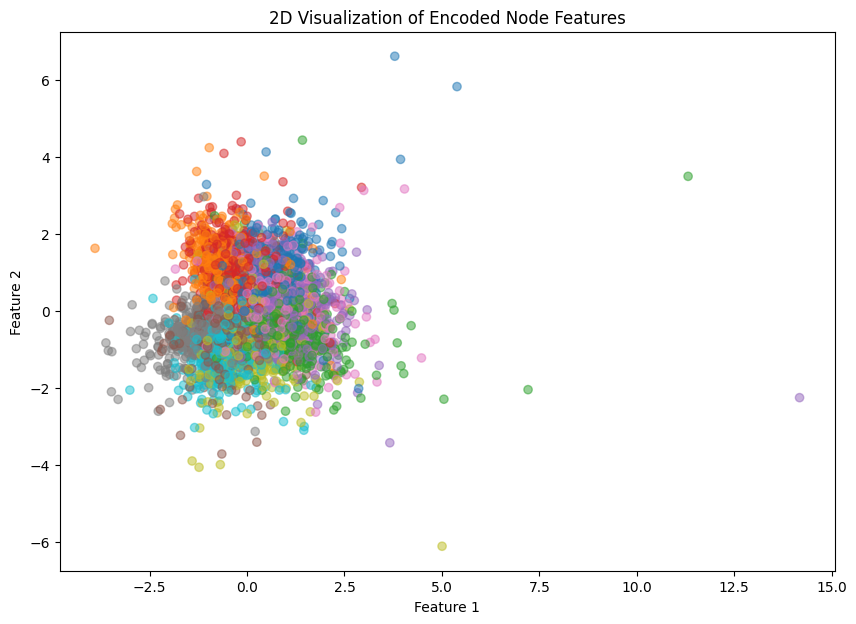

In [39]:
visualise(encoded_features, labels, '2D Visualization of Encoded Node Features')